In [85]:
from bitalg.visualizer.main import Visualizer
from typing import Tuple, List
from data import raw
from data.raw import EPSILON, P0
from numpy import sign
from functools import cmp_to_key

## Load Data

In [86]:
class Node:
    def __init__(self, x: float, y: float):
        # coordinates
        self.x = x
        self.y = y

        # neighbours
        self.nodesOut = []  # (Node,weight)
        self.nodesIn = []  # (Node,weight)

        # for weight processing
        self.wIn = 0
        self.wOut = 0

    def __str__(self):
        return f"{self.x,self.y}"

    def __repr__(self):
        return f"{self.x,self.y}"


def loadData(
    vertices: List[Tuple[float, float]], edges: List[Tuple[int, int]]
) -> List[Node]:  # zakladam, ze wierzcholki sa juz posortowane rosnaco
    """Loads data from raw.py file"""
    Nodes = [Node(x, y) for (x, y) in vertices]

    for i, j in edges:
        # validate input, so that i<j
        i, j = sorted([i, j])

        # initialize weights with 1's
        Nodes[i].nodesOut.append((Nodes[j], 1))
        Nodes[j].nodesIn.append((Nodes[i], 1))

    return Nodes

In [87]:
def sortEdges(vertices: List[Node]):
    """Sorts edges from rightmost to leftmost"""
    global P0
    for vertex in vertices:
        P0 = (vertex.x, vertex.y)
        vertex.nodesOut.sort(key=cmp_to_key(cmp1))
        vertex.nodesIn.sort(key=cmp_to_key(cmp2))


def det(a, b, c):
    result = (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])
    return result


def cmp1(n1: Tuple[Node, int], n2: Tuple[Node, int]):
    b = (n1[0].x, n1[0].y)
    c = (n2[0].x, n2[0].y)
    d = det(P0, b, c)
    if abs(d) < EPSILON:
        raise ValueError("Two edges with the same angle")
    else:
        return sign(-d)


def cmp2(n1: Tuple[Node, int], n2: Tuple[Node, int]):
    b = (n1[0].x, n1[0].y)
    c = (n2[0].x, n2[0].y)
    d = det(P0, b, c)
    if abs(d) < EPSILON:
        raise ValueError("Two edges with the same angle")
    else:
        return sign(d)

## Calculate weights

In [88]:
def calculateWeights(vertices: List[Node]):
    sortEdges(vertices)

    for vertex in vertices[1:-1]:  # without first and last vertex
        vertex.wIn = sum([w for (_, w) in vertex.nodesIn])
        vertex.wOut = len([w for (_, w) in vertex.nodesOut])

        if vertex.wIn > vertex.wOut:
            # v - leftmost Node
            (v, w) = vertex.nodesOut.pop()
            vertex.nodesOut.append((v, w + vertex.wIn - vertex.wOut))
            # change in v's nodesIn
            idx = v.nodesIn.index((vertex, w))
            v.nodesIn[idx] = (vertex, w + vertex.wIn - vertex.wOut)

    for vertex in reversed(vertices[1:-1]):  # without first and last vertex
        # vertex.wIn = sum([w for (_, w) in vertex.nodesIn])
        vertex.wOut = sum([w for (_, w) in vertex.nodesOut])

        if vertex.wOut > vertex.wIn:
            # v - leftmost Node
            (v, w) = vertex.nodesIn.pop()
            vertex.nodesIn.append((v, w + vertex.wOut - vertex.wIn))
            # change in v's nodesOut
            idx = v.nodesOut.index((vertex, w))
            v.nodesOut[idx] = (vertex, w + vertex.wOut - vertex.wIn)

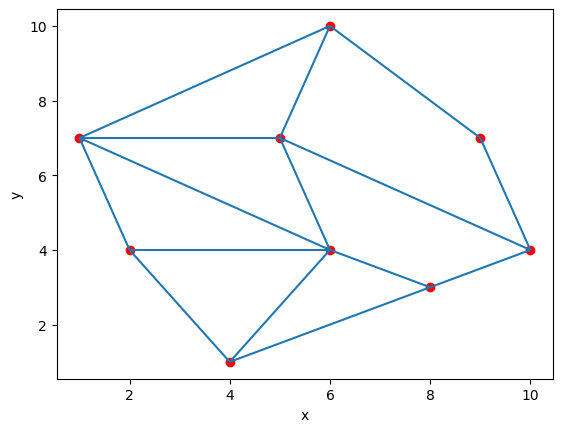

In [89]:
vertices = loadData(raw.vertices, raw.edges)
# visualize graph
vis = Visualizer()
points = [(n.x, n.y) for n in vertices]
segments = []
for n in vertices:
    for out in n.nodesOut:
        segments.append(((n.x, n.y), (out[0].x, out[0].y)))
vis.add_point(points, color="red")
vis.add_line_segment(segments)
vis.show()

In [90]:
calculateWeights(vertices)
for vertex in vertices:
    print(f"VERTEX {vertex.x,vertex.y}")
    print("IN: ", end="")
    for n, w in vertex.nodesIn:
        print(f"{n} {w}", end=" | ")
    print()
    print("OUT: ", end="")
    for n, w in vertex.nodesOut:
        print(f"{n} {w}", end=" | ")
    print()

VERTEX (4, 1)
IN: 
OUT: (8, 3) 3 | (6, 4) 1 | (2, 4) 2 | 
VERTEX (8, 3)
IN: (4, 1) 3 | 
OUT: (10, 4) 2 | (6, 4) 1 | 
VERTEX (2, 4)
IN: (4, 1) 2 | 
OUT: (6, 4) 1 | (1, 7) 1 | 
VERTEX (6, 4)
IN: (8, 3) 1 | (4, 1) 1 | (2, 4) 1 | 
OUT: (5, 7) 1 | (1, 7) 2 | 
VERTEX (10, 4)
IN: (8, 3) 2 | 
OUT: (9, 7) 1 | (5, 7) 1 | 
VERTEX (1, 7)
IN: (6, 4) 2 | (2, 4) 1 | 
OUT: (5, 7) 1 | (6, 10) 2 | 
VERTEX (5, 7)
IN: (10, 4) 1 | (6, 4) 1 | (1, 7) 1 | 
OUT: (6, 10) 3 | 
VERTEX (9, 7)
IN: (10, 4) 1 | 
OUT: (6, 10) 1 | 
VERTEX (6, 10)
IN: (9, 7) 1 | (5, 7) 3 | (1, 7) 2 | 
OUT: 


## Build separators

In [91]:
class Separator:
    def __init__(self):
        self.points = []
        self.edges = []

    def addPoint(self, point: Tuple[float, float]):
        self.points.append(point)

    def addEdge(self, edge: Tuple[Tuple[float, float], Tuple[float, float]]):
        self.edges.append(edge)

In [92]:
def findSeparators(graph):
    def buildSeparator(source: Node, separator: Separator):
        point = source
        while len(point.nodesOut)!=0:
            separator.addPoint((point.x,point.y))
            out = point.nodesOut
            # find lefmost non-zero weight edge
            i = len(out) - 1
            while out[i][1] == 0:
                i -= 1
            out[i] = (out[i][0], out[i][1] - 1)
            point=out[i][0]
        # add sink
        separator.addPoint((point.x,point.y))

    # number of separators
    n = sum([w for (_, w) in graph[0].nodesOut])
    separators = [Separator() for _ in range(n)]
    for i in range(n):
        buildSeparator(graph[0], separators[i])

    # build edges
    for i in range(n):
        points = separators[i].points
        for o in range(len(points) - 1):
            separators[i].addEdge((points[o], points[o + 1]))
    return separators

In [93]:
separators = findSeparators(vertices)

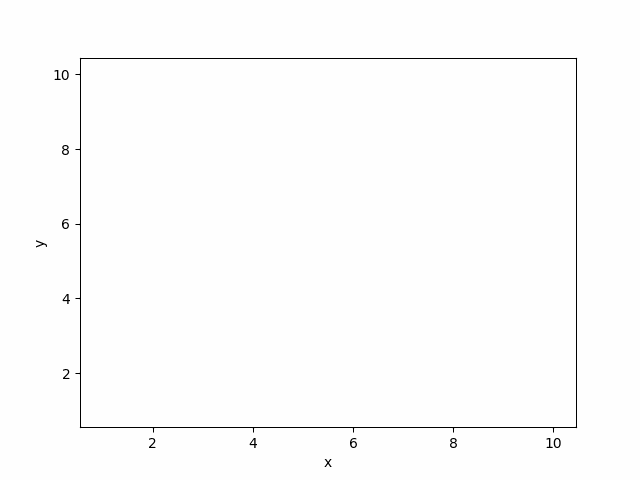

In [94]:
for separator in separators:
    to_remove = vis.add_line_segment(separator.edges, color="black")
    vis.remove_figure(to_remove)
vis.show_gif(interval=500)

## Build a BST

In [95]:
class TreeNode:
    def __init__(self, segments: List[Tuple[Tuple[float, float], Tuple[float, float]]]):
        self.right  = None
        self.left = None
        self.segments = segments

In [96]:
visited = set()


def arrayToBST(array: List):
    global visited

    if not array:
        return None
    # build root
    mid = len(array) // 2
    newEdges = []
    for edge in array[mid].edges:
        # odcinki w edges zawsze sa posortowane ? (a,b) -> a<=b (chyba tak), jezeli nie trzeba sprawdzic dla edge=(a,b): (b,a) not in visited
        if edge not in visited:
            newEdges.append(edge)
            visited.add(edge)
    print(newEdges)
    root = TreeNode(newEdges)
    root.left = arrayToBST(array[:mid])

    root.right = arrayToBST(array[mid + 1 :])

    return root

In [97]:
def printTree(node, level=0):
    if node != None:
        printTree(node.left, level + 1)
        print(' ' * 4 * level + '-> ' + str(len(node.segments)))
        printTree(node.right, level + 1)

In [98]:
root = arrayToBST(separators)

[((4, 1), (8, 3)), ((8, 3), (6, 4)), ((6, 4), (5, 7)), ((5, 7), (6, 10))]
[((4, 1), (2, 4)), ((2, 4), (6, 4)), ((6, 4), (1, 7)), ((1, 7), (6, 10))]
[((2, 4), (1, 7))]
[((4, 1), (6, 4)), ((1, 7), (5, 7))]
[((8, 3), (10, 4)), ((10, 4), (9, 7)), ((9, 7), (6, 10))]
[((10, 4), (5, 7))]


In [99]:
printTree(root) # liczby to ilosc odcinkow w danym TreeNode

        -> 1
    -> 4
        -> 2
-> 4
        -> 1
    -> 3
